In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
# Enable inline plotting  
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [132]:
cores_per_node = {
                  '1': [1, 4, 8, 16, 28],
                  '2': [28, 42, 56],
                  '4': [84, 98, 112],
                  '6': [140, 154, 168],
                  '8': [196, 210, 224],
                  '12': [308, 322, 336],
                  '16': [420, 434, 448]
                  }

repeats = 3

In [133]:
def reduce_to_means(N, n):
    """Helper function to reduce data from numpy arrays.
    
    First it takes the mean across all ranks for each timing,
    then it takes the mean and standard deviation across the repeats.
    
    Parameters
    ----------
    n : int
        number of processes used in run
        
    Returns
    -------
    means : list
        mean across number of repeats for each timing
    stds : list
        standard deviation across repeats for each timing
        
    """
    #fixes missing data
    if N == 16:
        repeats = 1
    else:
        repeats = 3
    
    init_total = np.empty(3)
    init_top = np.empty_like(init_total)
    init_traj = np.empty_like(init_total)
    open_traj = np.empty_like(init_total)
    n_atoms = np.empty_like(init_total)
    set_units = np.empty_like(init_total)
    io = np.empty_like(init_total)
    io_per_frame = np.empty_like(init_total)
    copy_data = np.empty_like(init_total)
    copy_box = np.empty_like(init_total)
    get_dataset = np.empty_like(init_total)
    set_ts_position = np.empty_like(init_total)
    convert_units = np.empty_like(init_total)
    rmsd = np.empty_like(init_total)
    rmsd_per_frame = np.empty_like(init_total)
    wait = np.empty_like(init_total)
    comm_gather = np.empty_like(init_total)
    total = np.empty_like(init_total)

    _dict = {f'a{i}': np.load(f'{N}node_{i}/{n}process_times.npy') for i in range(1, repeats+1)}

    for i, array in enumerate(_dict.values()):
        init_total[i] = np.mean(array[:, 1])
        init_top[i] = np.mean(array[:, 2])
        init_traj[i] = np.mean(array[:, 3])
        open_traj[i] = np.mean(array[:, 4])
        n_atoms[i] = np.mean(array[:, 5])
        set_units[i] = np.mean(array[:, 6])
        io[i] = np.mean(array[:, 7])
        io_per_frame[i] = np.mean(array[:, 8])
        copy_data[i] = np.mean(array[:, 9])
        copy_box[i] = np.mean(array[:, 10])
        get_dataset[i] = np.mean(array[:, 11])
        set_ts_position[i] = np.mean(array[:, 12])
        convert_units[i] = np.mean(array[:, 13])
        rmsd[i] = np.mean(array[:, 14])
        rmsd_per_frame[i] = np.mean(array[:, 15])
        wait[i] = np.mean(array[:, 16])
        comm_gather[i] = np.mean(array[:, 17])
        total[i] = np.mean(array[:, 18])

    means = [n, np.mean(init_total), np.mean(init_top), np.mean(init_traj), np.mean(open_traj), 
             np.mean(n_atoms), np.mean(set_units), np.mean(io), np.mean(io_per_frame),
             np.mean(copy_data), np.mean(copy_box), np.mean(get_dataset), np.mean(set_ts_position), np.mean(convert_units),
             np.mean(rmsd), np.mean(rmsd_per_frame), np.mean(wait), np.mean(comm_gather), np.mean(total)]
    stds = [n, np.std(init_total), np.std(init_top), np.std(init_traj), np.std(open_traj), 
             np.std(n_atoms), np.std(set_units), np.std(io), np.std(io_per_frame),
             np.std(copy_data), np.std(copy_box), np.std(get_dataset), np.std(set_ts_position), np.std(convert_units),
             np.std(rmsd), np.std(rmsd_per_frame), np.std(wait), np.std(comm_gather), np.std(total)]

    return means, stds

In [134]:
def get_raw_data(N, n, averaged=False):
    """Gets the raw data from all repeats and displays in a pandas DataFrame.
    
    If averaged=True, it takes the average and standard deviation across all 
    repeats for all (rank x timing) elements.
    
    Parameters
    ----------
    n : int
        number of processes used in run
    averaged: bool (optional)
    
    Returns
    -------
    all data (if averaged=False) : pd.DataFrame
        pandas dataframe of raw data arrays stacked horizontally with no reductions
    means (if averaged=True) : pd.DataFrame
        mean across repeats for each (rank x timing) element
    stds (if averaged=True) : pd.DataFrame 
        standard deviation across repeats for each (rank x timing) element
    
    """
    
    
    columns = ['rank', 'init_total', 'init_topology', 'init_trajectory', 
               'open_traj', 'n_atoms', 'set_units', 'io', 'io/frame',
               'copy_data', 'copy_box', 'get_dataset', 'set_ts_position', 'convert_units',
               'rmsd_compute', 'rmsd_compute/frame', 'wait', 'comm_gather',
               'total bench']
    
    _dict = {f'a{i}': np.load(f'{N}node_{i}/{n}process_times.npy') for i in range(1, repeats+1)}
    
    if averaged:
        means_buffer = np.zeros(shape=(n,19), dtype=float)
        stds_buffer = np.zeros(shape=(n,19), dtype=float)
        
        # fills in means and std arrays 1 element at a time
        for i in range(n):
            for j in range(19):
                temp_array = np.empty(repeats, dtype=float) 
                for trial, k in enumerate(range(len(temp_array)), 1):
                    temp_array[k] = _dict[f'a{trial}'][i, j]
                means_buffer[i, j] = np.mean(temp_array)
                stds_buffer[i, j] = np.std(temp_array)
                
        return pd.DataFrame(list(means_buffer), columns=columns).set_index('rank'), pd.DataFrame(list(stds_buffer), columns=columns).set_index('rank')
    
    else:
        arrays = tuple(_dict.values())
        a = np.hstack(arrays)
        
        return pd.DataFrame(list(a), columns=repeats*columns)

In [135]:
def all_process_dataframe():
    """Gives DataFrame of averaged timings for all N_process runs.
    
    Returns
    -------
    times_dframe : pd.DataFrame
        benchmark times with timings first averaged across all ranks, then averaged across repeats
    stds_dframe : pd.DataFrame 
        standard deviation of the timings when averaged across repeats   
    
    """
    columns = ['N_Processes', 'Total_Initialize', 'Initialize_Topology', 
                'Initialize_Trajectory', 'Open_Trajectory', 'Set_n_atoms',
                'Set_Units', 'IO', 'IO/Frame', 'Copy_Data', 'Copy_Box',
                'Get_Dataset', 'Set_ts_Position', 'Convert_Units',
                'RMSD', 'RMSD/Frame', 'Wait', 'Comm_Gather', 'Total_Benchmark_Time']
    
    data_buffer = np.empty(shape=(20,19), dtype=float)
    stds_buffer = np.empty(shape=(20,19), dtype=float)
    
    count = -1
    for N in [1,2,4,6,8,12]:
        for i, cores in enumerate(cores_per_node[f'{N}'], count+1):
            count = i
            means, stds = reduce_to_means(N, cores)
            for j in range(19):
                data_buffer[i, j] = means[j]
                stds_buffer[i, j] = stds[j]

    times_dframe = pd.DataFrame(list(data_buffer), columns=columns).set_index('N_Processes')
    stds_dframe = pd.DataFrame(list(stds_buffer), columns=columns).set_index('N_Processes')
            
    return times_dframe, stds_dframe

In [136]:
def plot_line_graph(timing_dataframe, stds_dataframe=None):
        
        if stds_dataframe is not None:
            t_io_stds = stds_dataframe.IO.to_numpy()
            t_rmsd_stds = stds_dataframe.RMSD.to_numpy()
            t_init_total_stds = stds_dataframe.Total_Initialize.to_numpy()
            t_init_top_stds = stds_dataframe.Initialize_Topology.to_numpy()
            t_init_traj_stds = stds_dataframe.Initialize_Trajectory.to_numpy()
            t_wait_stds = stds_dataframe.Wait.to_numpy()
            t_comm_stds = stds_dataframe.Comm_Gather.to_numpy()

        plt.rcParams['font.size'] = 9
        sns.set_style('ticks')
        fig = plt.figure(figsize=(10,10))
        axes = fig.add_subplot(1,1,1)
        yerrs = [t_io_stds, t_rmsd_stds, t_init_top_stds, t_init_traj_stds, t_wait_stds, t_comm_stds]
        timing_dataframe.loc[:, ['IO','RMSD','Initialize_Topology',
                      'Initialize_Trajectory','Wait','Comm_Gather']].plot(color=['blue',
                                                                            'orange', 
                                                                            'black',
                                                                            'green',
                                                                            'purple',
                                                                            'red'], yerr=yerrs, ax=axes, marker='o')
        lgd = plt.legend(['IO', 'RMSD','Initialize Topology', 
                              'Initialize Trajectory','Wait', 'Communication'],
                             loc='upper center', bbox_to_anchor=(0.5, -0.2),
                             frameon=False, shadow=False, ncol=2, prop={'size':12})
        axes.set_xlabel('$N_{Processes}$', fontsize=18)
        axes.set_ylabel('Time (s)', fontsize=18)
        #axes.set_title('900 Frame Trajectory on 12-core Local Workstation', fontsize=24)
        plt.xscale('log')
        plt.yscale('log')
        #axes.set_ylim(0,10000)
        axes.set_xlim(1, 460)
        axes.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        
        plt.tight_layout()
        fig.subplots_adjust(bottom=0.4)

In [137]:
def plot_init_breakdown_line(timing_dataframe, stds_dataframe=None):
        
        if stds_dataframe is not None:
            t_init_traj_stds = stds_dataframe.Initialize_Trajectory.to_numpy()
            t_open_traj_stds = stds_dataframe.Open_Trajectory.to_numpy()
            t_n_atoms_stds = stds_dataframe.Set_n_atoms.to_numpy()
            t_set_units_stds = stds_dataframe.Set_Units.to_numpy()

        plt.rcParams['font.size'] = 9
        sns.set_style('ticks')
        fig = plt.figure(figsize=(10,10))
        axes = fig.add_subplot(1,1,1)
        yerrs = [t_init_traj_stds, t_open_traj_stds, t_n_atoms_stds, t_set_units_stds]
        timing_dataframe.loc[:, ['Initialize_Trajectory','Open_Trajectory','Set_n_atoms','Set_Units']].plot(color=['green',
                                                                                                        'blue', 
                                                                                                        'black',
                                                                                                        'red'], 
                                                                                                  yerr=yerrs, 
                                                                                                  ax=axes, 
                                                                                                  marker='o')
        lgd = plt.legend(['Initialize Trajectory', 'Open File','Set n_atoms','Set Units'],
                             loc='upper center', bbox_to_anchor=(0.5, -0.2),
                             frameon=False, shadow=False, ncol=2, prop={'size':12})
        axes.set_xlabel('$N_{Processes}$', fontsize=18)
        axes.set_ylabel('Time (s)', fontsize=18)
        #axes.set_title('900 Frame Trajectory on 12-core Local Workstation', fontsize=24)
        plt.xscale('log')
        plt.yscale('log')
        #axes.set_ylim(0,10000)
        axes.set_xlim(1, 460)
        axes.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        
        plt.tight_layout()
        fig.subplots_adjust(bottom=0.4)

In [138]:
def plot_io_breakdown_line(timing_dataframe, stds_dataframe=None):
        
        if stds_dataframe is not None:
            t_io_stds = stds_dataframe.IO.to_numpy()
            t_data_stds = stds_dataframe.Copy_Data.to_numpy()
            t_get_pos_stds = stds_dataframe.Get_Dataset.to_numpy()
            t_set_pos_stds = stds_dataframe.Set_ts_Position.to_numpy()
            t_box_stds = stds_dataframe.Copy_Box.to_numpy()
            t_convert_units_stds = stds_dataframe.Convert_Units.to_numpy()

        plt.rcParams['font.size'] = 9
        sns.set_style('ticks')
        fig = plt.figure(figsize=(10,10))
        axes = fig.add_subplot(1,1,1)
        yerrs = [t_io_stds, t_data_stds, t_get_pos_stds, t_set_pos_stds, t_box_stds, t_convert_units_stds]
        timing_dataframe.loc[:, ['IO','Copy_Data','Get_Dataset','Set_ts_Position','Copy_Box','Convert_Units']].plot(color=['black',
                                                                                                        'orange', 
                                                                                                        'blue',
                                                                                                        'purple',
                                                                                                        'green',
                                                                                                        'red'], 
                                                                                                  yerr=yerrs, 
                                                                                                  ax=axes, 
                                                                                                  marker='o')
        lgd = plt.legend(['Total IO','Fill Data', 'Get Dataset','Set Position ts', 
                              'Fill Box','Convert Units'],
                             loc='upper center', bbox_to_anchor=(0.5, -0.2),
                             frameon=False, shadow=False, ncol=2, prop={'size':12})
        axes.set_xlabel('$N_{Processes}$', fontsize=18)
        axes.set_ylabel('Time (s)', fontsize=18)
        #axes.set_title('900 Frame Trajectory on 12-core Local Workstation', fontsize=24)
        plt.xscale('log')
        plt.yscale('log')
        #axes.set_ylim(0,10000)
        axes.set_xlim(1, 460)
        axes.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        
        plt.tight_layout()
        fig.subplots_adjust(bottom=0.4)

In [139]:
def plot_io_scaling(timing_dataframe, stds_dataframe=None, init_subtracted=False):
        
    n_proc = timing_dataframe.index.to_numpy()
    t_io = timing_dataframe.IO.to_numpy()
    t_data = timing_dataframe.Copy_Data.to_numpy()
    t_box = timing_dataframe.Copy_Box.to_numpy()
    t_get_pos = timing_dataframe.Get_Dataset.to_numpy()
    t_set_pos = timing_dataframe.Set_ts_Position.to_numpy()

    speedup_io = [t_io[0]/t_io[i] for i in range(len(t_io))]
    efficiency_io = [speedup_io[i]/n_proc[i] for i in range(len(t_io))]
    
    speedup_data = [t_data[0]/t_data[i] for i in range(len(t_data))]
    efficiency_data = [speedup_data[i]/n_proc[i] for i in range(len(t_data))]
    
    speedup_box = [t_box[0]/t_box[i] for i in range(len(t_box))]
    efficiency_box = [speedup_box[i]/n_proc[i] for i in range(len(t_box))]
    
    speedup_get_pos = [t_get_pos[0]/t_get_pos[i] for i in range(len(t_get_pos))]
    efficiency_get_pos = [speedup_get_pos[i]/n_proc[i] for i in range(len(t_get_pos))]
    
    speedup_set_pos = [t_set_pos[0]/t_set_pos[i] for i in range(len(t_set_pos))]
    efficiency_set_pos = [speedup_set_pos[i]/n_proc[i] for i in range(len(t_set_pos))]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    plt.style.use('ggplot')
    sns.set_style('ticks')

    ax1.plot(n_proc, n_proc, 'k--', linewidth='3.5')
    ax1.plot(n_proc, speedup_io, marker='.', color='black', label='Total IO', linewidth='3')
    ax1.plot(n_proc, speedup_data, marker='.', color='orange', label='Copy Data', linewidth='3')
    ax1.plot(n_proc, speedup_box, marker='.', color='blue', label='Fill Box', linewidth='3')
    ax1.plot(n_proc, speedup_get_pos, marker='.', color='red', label='Get Position Dataset', linewidth='3')
    ax1.plot(n_proc, speedup_set_pos, marker='.', color='purple', label='Set Position ts', linewidth='3')
    ax1.set(xlim=[1,448], ylim=[1,448], title='Speedup', ylabel='Speedup')
    ax1.set_title('Speedup', fontsize=24)
    ax1.set_xlabel('$N_{Processes}$', fontsize=24)
    ax1.set_ylabel('$S(N) = t_1/t_N$', fontsize=24)
    ax1.legend(fontsize=20)
    ax1.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax1.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax1.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    ax1.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    
    ax2.plot(n_proc, efficiency_io, marker='.', color='black', label='Total IO', linewidth='3')
    ax2.plot(n_proc, efficiency_data, marker='.', color='orange', label='Copy Data',  linewidth='3')
    ax2.plot(n_proc, efficiency_box, marker='.', color='blue', label='Fill Box', linewidth='3')
    ax2.plot(n_proc, efficiency_get_pos, marker='.', color='red', label='Get Position Dataset', linewidth='3')
    ax2.plot(n_proc, efficiency_set_pos, marker='.', color='purple', label='Set Position ts', linewidth='3')
    ax2.set(xlim=[1,448], ylim=[0,1.2])
    ax2.set_title('Efficiency', fontsize=24)
    ax2.set_xlabel('$N_{Processes}$', fontsize=24)
    ax2.set_ylabel('E(N) = S(N)/N', fontsize=24)
    ax2.legend(fontsize=20)
    ax2.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax2.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax2.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    ax2.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')

In [140]:
def plot_scaling(timing_dataframe, stds_dataframe=None, full_nodes=False, init_subtracted=False):
        
    n_proc = timing_dataframe.index.to_numpy()
    t_io = timing_dataframe.IO.to_numpy()
    t_init = timing_dataframe.Total_Initialize.to_numpy()
    t_rmsd = timing_dataframe.RMSD.to_numpy()
    t_total = timing_dataframe.Total_Benchmark_Time.to_numpy()
    
    if full_nodes:
        n_proc = n_proc[[0, 4, 7, 10, 13, 16, 19]]
        t_io = t_io[[0, 4, 7, 10, 13, 16, 19]]
        t_init = t_init[[0, 4, 7, 10, 13, 16, 19]]
        t_rmsd = t_rmsd[[0, 4, 7, 10, 13, 16, 19]]
        t_total = t_total[[0, 4, 7, 10, 13, 16, 19]]
    
    if init_subtracted:
        t_total = t_total - t_init
        
    speedup_rmsd = [t_rmsd[0]/t_rmsd[i] for i in range(len(t_rmsd))]
    efficiency_rmsd = [speedup_rmsd[i]/n_proc[i] for i in range(len(t_rmsd))]
    speedup_io = [t_io[0]/t_io[i] for i in range(len(t_io))]
    efficiency_io = [speedup_io[i]/n_proc[i] for i in range(len(t_io))]
    speedup_total = [t_total[0]/t_total[i] for i in range(len(t_total))]
    efficiency_total = [speedup_total[i]/n_proc[i] for i in range(len(t_total))]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    plt.style.use('ggplot')
    sns.set_style('ticks')

    ax1.plot(n_proc, n_proc, 'k--', linewidth='3.5')
    ax1.plot(n_proc, speedup_rmsd, marker='o', color='orange', label='RMSD', linewidth='3')
    ax1.plot(n_proc, speedup_io, marker='o', color='blue', label='IO', linewidth='3')
    ax1.plot(n_proc, speedup_total, linestyle='--', marker='o', color='red', label='Total', linewidth='3')
    ax1.set(xlim=[1,336], ylim=[1,336], title='Speedup')
    ax1.set_title('Speedup', fontsize=24)
    ax1.set_xlabel('$N_{Processes}$', fontsize=24)
    ax1.set_ylabel('$S(N) = t_1/t_N$', fontsize=24)
    ax1.legend(fontsize=20)
    ax1.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax1.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax1.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    ax1.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    
    ax2.plot(n_proc, efficiency_rmsd, marker='o', color='orange', label='RMSD',  linewidth='3')
    ax2.plot(n_proc, efficiency_io, marker='o', color='blue', label='IO', linewidth='3')
    ax2.plot(n_proc, efficiency_total, marker='o', color='red', label='Total', linewidth='3')
    ax2.set(xlim=[1,336], ylim=[0,1.2])
    ax2.set_title('Efficiency', fontsize=24)
    ax2.set_xlabel('$N_{Processes}$', fontsize=24)
    ax2.set_ylabel('E(N) = S(N)/N', fontsize=24)
    ax2.legend(fontsize=20)
    ax2.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax2.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax2.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    ax2.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')

In [141]:
means,stds = all_process_dataframe()
means

,Total_Initialize,Initialize_Topology,Initialize_Trajectory,Open_Trajectory,Set_n_atoms,Set_Units,IO,IO/Frame,Copy_Data,Copy_Box,Get_Dataset,Set_ts_Position,Convert_Units,RMSD,RMSD/Frame,Wait,Comm_Gather,Total_Benchmark_Time
N_Processes,,,,,,,,,,,,,,,,,,
1.0,0.279236,0.044284,0.234597,0.115724,0.070527,0.001391,2581.543105,0.028652,104.264420,83.362609,2317.499774,0.796387,15.837886,13.853556,0.000154,0.000022,0.000447,2595.676366
4.0,0.603386,0.124753,0.478192,0.107894,0.144537,0.001809,690.360027,0.030649,27.173476,20.360893,623.079563,0.211179,4.046112,3.485584,0.000155,118.959867,0.000286,813.409150
8.0,0.446272,0.029686,0.416151,0.320577,0.032316,0.001381,334.170957,0.029671,13.715009,10.433916,299.434536,0.132009,2.297743,1.806031,0.000160,58.466273,0.000473,394.890006
16.0,0.324817,0.026733,0.297642,0.175112,0.076091,0.001685,144.527105,0.025665,6.205245,4.655674,128.354051,0.082000,1.285754,0.903714,0.000160,27.797515,0.000398,173.553549
28.0,0.383831,0.016393,0.367088,0.308916,0.024999,0.001089,80.926514,0.025149,3.628840,2.659994,71.445777,0.051313,0.785160,0.527379,0.000164,9.006045,0.000400,90.844169
28.0,0.731457,0.019412,0.711571,0.487153,0.104636,0.001552,168.027880,0.052217,8.523530,8.918263,145.627622,0.054572,0.867561,0.598494,0.000186,7.507520,0.000397,176.865748
42.0,0.913564,0.038485,0.874591,0.805103,0.031219,0.001398,68.186238,0.031785,3.769230,3.305122,58.734220,0.033959,0.529489,0.355069,0.000166,6.576645,0.000415,76.031930
56.0,0.692379,0.017931,0.674015,0.576633,0.037703,0.002572,50.494537,0.031384,2.537932,2.202266,43.899671,0.026160,0.408192,0.270241,0.000168,5.192615,0.000520,56.650292
84.0,0.607826,0.139331,0.468015,0.305979,0.078459,0.001990,47.836311,0.044597,2.000994,2.362752,41.679372,0.018043,0.287141,0.192306,0.000179,3.361921,0.000834,51.999199


In [142]:
get_raw_data(12, 308)

,rank,init_total,init_topology,init_trajectory,open_traj,n_atoms,set_units,io,io/frame,copy_data,copy_box,get_dataset,set_ts_position,convert_units,rmsd_compute,rmsd_compute/frame,wait,comm_gather,total bench,rank,init_total,init_topology,init_trajectory,open_traj,n_atoms,set_units,io,io/frame,copy_data,copy_box,get_dataset,set_ts_position,convert_units,rmsd_compute,rmsd_compute/frame,wait,comm_gather,total bench,rank,init_total,init_topology,init_trajectory,open_traj,n_atoms,set_units,io,io/frame,copy_data,copy_box,get_dataset,set_ts_position,convert_units,rmsd_compute,rmsd_compute/frame,wait,comm_gather,total bench
0,0.0,1.307585,0.041240,1.265656,0.933901,0.203150,0.003778,70.161045,0.239457,4.452776,3.312587,55.891213,0.006669,0.114594,0.083501,0.000285,6.550318,0.013745,78.116195,0.0,0.503088,0.015540,0.487036,0.355999,0.072130,0.002685,14.414467,0.049196,0.929776,0.340362,12.302398,0.005220,0.080652,0.052337,0.000179,1.709672,0.012429,16.691993,0.0,0.744349,0.017961,0.725725,0.613511,0.042513,0.003788,13.621236,0.046489,0.827561,0.247710,11.780419,0.004839,0.077791,0.049922,0.000170,1.542657,0.013584,15.971749
1,1.0,1.557554,0.026189,1.530628,1.218137,0.180881,0.003388,73.193986,0.249809,4.928276,5.710149,56.772412,0.006165,0.112344,0.079841,0.000272,3.518663,0.000073,78.350118,1.0,0.374086,0.017569,0.355978,0.246628,0.044807,0.007083,15.153602,0.051719,0.816789,0.558499,12.944540,0.004659,0.078557,0.052874,0.000180,0.990894,0.000062,16.571517,1.0,2.162418,0.055426,2.106007,1.905926,0.081089,0.002106,14.051215,0.047956,0.822259,0.500955,11.960072,0.004887,0.074992,0.050338,0.000172,1.011535,0.000088,17.275594
2,2.0,1.170490,0.022943,1.146941,0.806459,0.200655,0.002646,74.741895,0.255092,2.550758,10.518547,56.628458,0.006752,0.116630,0.084990,0.000290,1.956894,0.000081,77.954350,2.0,0.479781,0.015420,0.463853,0.357760,0.038080,0.006860,15.506182,0.052922,0.922358,1.137256,12.654695,0.004739,0.082163,0.054929,0.000187,0.647481,0.000105,16.688478,2.0,0.725487,0.016802,0.708002,0.585896,0.071621,0.000998,14.459311,0.049349,0.813447,1.071174,11.814151,0.005023,0.077219,0.051005,0.000174,0.689645,0.000102,15.925550
3,3.0,1.436963,0.047168,1.388866,0.987023,0.187503,0.004526,75.440995,0.257478,4.669525,12.011034,53.274834,0.006247,0.112776,0.079250,0.000270,1.187042,0.000053,78.144303,3.0,0.485584,0.017236,0.467726,0.301010,0.083169,0.004274,15.488688,0.052862,0.945204,1.134178,12.568900,0.004664,0.078287,0.053059,0.000181,0.602596,0.000075,16.630001,3.0,0.766523,0.018471,0.747502,0.621074,0.073467,0.001121,14.223919,0.048546,0.804965,1.128178,11.548193,0.004527,0.073126,0.048945,0.000167,0.920046,0.000074,15.959507
4,4.0,1.380886,0.044651,1.335639,1.006256,0.191251,0.001396,75.094461,0.256295,2.482054,10.249967,57.183796,0.006345,0.114143,0.080958,0.000276,1.618201,0.000076,78.174583,4.0,0.405086,0.017215,0.387364,0.290334,0.029002,0.000942,15.463876,0.052778,0.891566,1.179888,12.551174,0.004895,0.079740,0.052515,0.000179,0.705564,0.000093,16.627133,4.0,1.618335,0.054689,1.563075,1.433130,0.081189,0.000988,14.476225,0.049407,0.789246,1.156185,11.748066,0.005108,0.077907,0.050930,0.000174,0.665740,0.000117,16.811347
5,5.0,1.751267,0.036832,1.713755,1.418009,0.176341,0.001730,75.382215,0.257277,3.059823,9.168836,58.327399,0.005967,0.111707,0.078984,0.000270,1.354374,0.000066,78.566906,5.0,0.430196,0.016400,0.413291,0.314117,0.043175,0.003721,15.413853,0.052607,0.850262,1.179880,12.593303,0.004647,0.077722,0.051075,0.000174,0.744065,0.000051,16.639240,5.0,1.077036,0.027226,1.048939,0.858915,0.084486,0.001864,14.483488,0.049432,0.813445,1.060896,11.839846,0.004481,0.072386,0.049081,0.000168,0.588686,0.000073,16.198364
6,6.0,1.348840,0.048687,1.299140,0.978802,0.188825,0.003453,74.847044,0.255451,4.133221,10.334034,54.272146,0.006453,0.115804,0.081520,0.000278,1.863748,0.000082,78.141233,6.0,0.371756,0.018357,0.352882,0.236006,0.055159,0.003108,15.258513,0.052077,0.868735,1.222501,12.413060,0.005025,0.079192,0.053049,0.000181,0.880

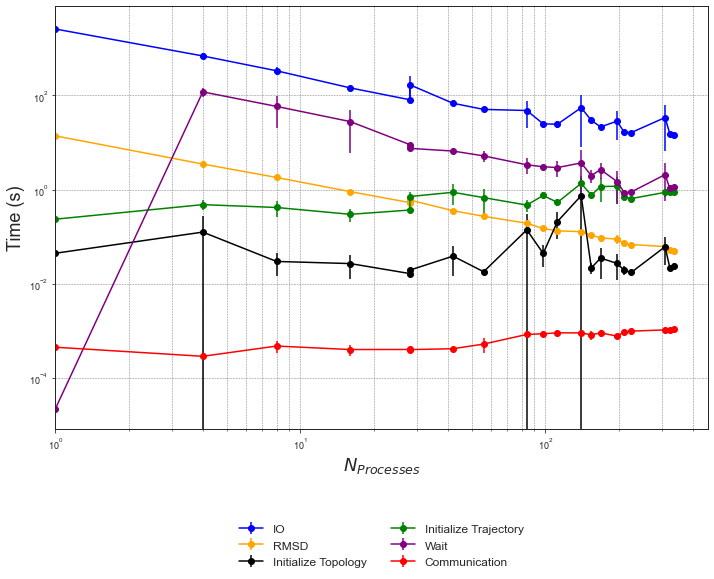

In [143]:
plot_line_graph(means, stds)

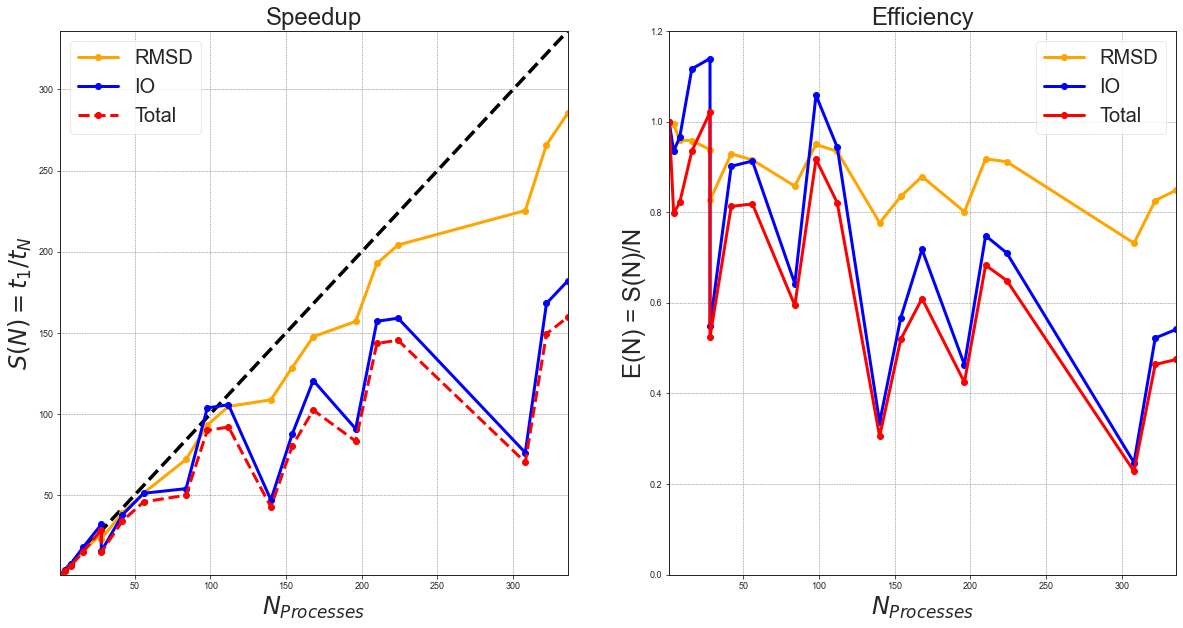

In [144]:
plot_scaling(means, stds, init_subtracted=False)

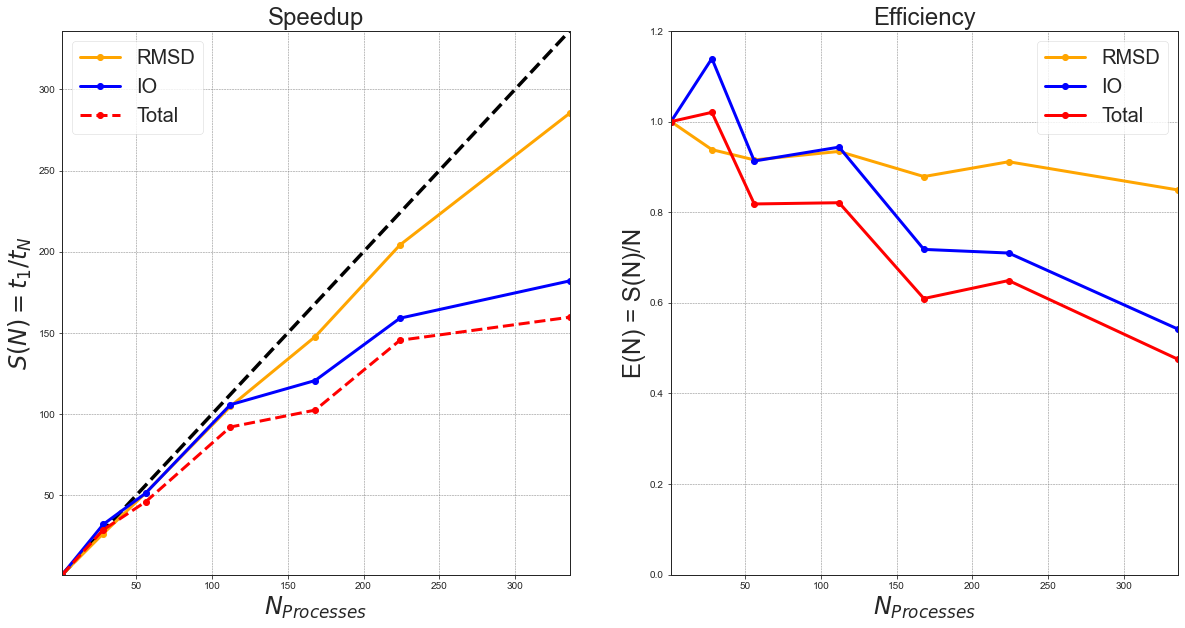

In [145]:
plot_scaling(means,stds, full_nodes=True)

In [99]:
full = means.index.to_numpy()
full

array([  1.,   4.,   8.,  16.,  28.,  28.,  42.,  56.,  84.,  98., 112.,
       140., 154., 168., 196., 210., 224., 308., 322., 336.])

In [100]:
io = means.IO.to_numpy()
io

array([2581.54310465,  690.36002731,  334.17095665,  144.52710509,
         80.92651442,  168.02787986,   68.18623751,   50.49453665,
         47.83631135,   24.89638067,   24.42555403,   54.88013902,
         29.55050032,   21.40518894,   28.42324133,   16.43138654,
         16.2347692 ,   33.89138783,   15.3535532 ,   14.18588086])

In [101]:
a = np.load('16node_1/420process_times.npy')
pd.DataFrame(a, columns=['N_Processes', 'Total_Initialize', 'Initialize_Topology', 
                'Initialize_Trajectory', 'Open_Trajectory', 'Set_n_atoms',
                'Set_Units', 'IO', 'IO/Frame', 'Copy_Data', 'Copy_Box',
                'Get_Dataset', 'Set_ts_Position', 'Convert_Units',
                'RMSD', 'RMSD/Frame', 'Wait', 'Comm_Gather', 'Total_Benchmark_Time'])

,N_Processes,Total_Initialize,Initialize_Topology,Initialize_Trajectory,Open_Trajectory,Set_n_atoms,Set_Units,IO,IO/Frame,Copy_Data,Copy_Box,Get_Dataset,Set_ts_Position,Convert_Units,RMSD,RMSD/Frame,Wait,Comm_Gather,Total_Benchmark_Time
0,0.0,2.436033,0.016806,2.418157,0.587788,1.523379,0.010014,58.973924,0.274297,3.194280,4.885399,48.071116,0.004725,0.087294,0.062901,0.000293,5.145425,0.013560,66.631843
1,1.0,2.408053,0.044173,2.363042,0.677800,1.429011,0.012374,63.261590,0.294240,2.580895,4.069077,53.735044,0.004633,0.081721,0.057880,0.000269,1.001185,0.000070,66.728779
2,2.0,2.458050,0.034208,2.422943,0.751507,1.447180,0.079204,63.270578,0.294282,2.118359,6.579180,50.731256,0.004482,0.082989,0.059622,0.000277,1.012727,0.000084,66.801060
3,3.0,2.457572,0.018578,2.437993,0.595838,1.431853,0.009128,63.409075,0.294926,2.898106,7.443851,49.812264,0.004569,0.081529,0.058627,0.000273,0.698759,0.000068,66.624101
4,4.0,2.654593,0.016707,2.636729,0.571453,1.537282,0.004912,62.897741,0.292548,2.886744,6.538668,50.620366,0.004498,0.082822,0.058403,0.000272,0.990547,0.000073,66.601357
5,5.0,2.561430,0.046483,2.513813,0.673736,1.432960,0.006465,63.722337,0.296383,3.173506,6.771776,49.407367,0.004539,0.079817,0.056621,0.000263,0.391767,0.000075,66.732230
6,6.0,2.476026,0.080718,2.394229,0.654554,1.534380,0.011593,63.260184,0.294233,2.899766,8.845806,47.246140,0.004608,0.081362,0.058357,0.000271,0.962236,0.000056,66.756859
7,7.0,2.450006,0.018515,2.430391,0.602809,1.437139,0.007174,63.640098,0.296000,2.334295,6.124186,52.768659,0.004877,0.082926,0.058804,0.000274,0.483268,0.000047,66.632223
8,8.0,2.525330,0.124131,2.400012,0.689183,1.424955,0.010977,62.750483,0.291863,3.640416,7.681938,45.470147,0.004772,0.083925,0.061534,0.000286,1.477602,0.000081,66.815030
9,9.0,2.425002,0.018812,2.405031,0.576513,1.435584,0.007596,63.606598,0.295845,4.630552,10.430064,46.089542,0.004570,0.078873,0.056047,0.000261,0.519580,0.000062,66.607289
